In [ ]:
%pip install -q "openvino>=2023.1.0"

In [2]:
pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 63.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import RDConfig
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
import pandas as pd


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [4]:
# Replace 'path_to_file.tsv' with the actual file path
file_path = 'logd74.tsv'

# Load the dataset
df = pd.read_csv(file_path, delimiter='\t')

In [5]:
def smiles_to_fp(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return np.array(fp)

df['fp'] = df['SMILES'].apply(smiles_to_fp)


In [6]:
X = np.array(list(df['fp']))
y = df['logD7.4'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = Net()


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Epoch 1/100, Loss: 6.648157596588135
Epoch 2/100, Loss: 5.432311534881592
Epoch 3/100, Loss: 4.102224349975586
Epoch 4/100, Loss: 2.8275883197784424
Epoch 5/100, Loss: 2.735079526901245
Epoch 6/100, Loss: 2.831037759780884
Epoch 7/100, Loss: 2.1036057472229004
Epoch 8/100, Loss: 1.5018304586410522
Epoch 9/100, Loss: 1.2980132102966309
Epoch 10/100, Loss: 1.2536022663116455
Epoch 11/100, Loss: 1.1684857606887817
Epoch 12/100, Loss: 1.0146806240081787
Epoch 13/100, Loss: 0.8729823231697083
Epoch 14/100, Loss: 0.8414508104324341
Epoch 15/100, Loss: 0.9021915793418884
Epoch 16/100, Loss: 0.9045400023460388
Epoch 17/100, Loss: 0.7989816665649414
Epoch 18/100, Loss: 0.6754276752471924
Epoch 19/100, Loss: 0.6075586676597595
Epoch 20/100, Loss: 0.590531587600708
Epoch 21/100, Loss: 0.5808625817298889
Epoch 22/100, Loss: 0.5506933927536011
Epoch 23/100, Loss: 0.5063478946685791
Epoch 24/100, Loss: 0.47458162903785706
Epoch 25/100, Loss: 0.4714348018169403
Epoch 26/100, Loss: 0.47927194833755493

In [9]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

with torch.no_grad():
    predicted = model(X_test_tensor).squeeze()
    mse = mean_squared_error(y_test_tensor, predicted)
    print(f'Test MSE: {mse}')


Test MSE: 0.6821909546852112


In [10]:
torch.save(model.state_dict(), 'lipophilicity_model.pth')


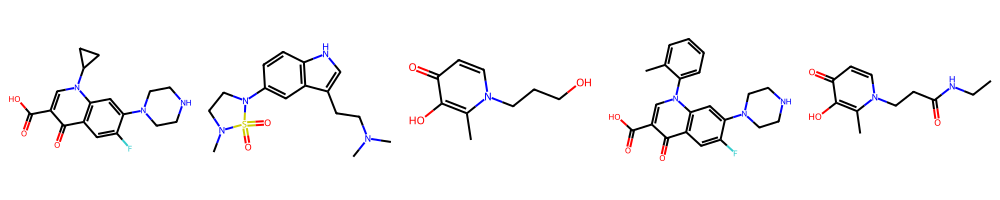

In [11]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES'][:5]]
img = Draw.MolsToImage(mols)
img.show()


In [12]:
import torch
import openvino.runtime as ov
from pathlib import Path

# Load your PyTorch model
model = Net()  # Assuming 'Net' is your model class
model.load_state_dict(torch.load('lipophilicity_model.pth'))
model.eval()



Net(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)

In [13]:
pip install onnx

Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch.onnx

dummy_input = torch.randn(1, 2048)  # Adjust the size according to your model input
torch.onnx.export(model, dummy_input, "model.onnx", opset_version=11)


In [16]:
# Create OpenVINO Core object instance
core = ov.Core()

# Read the ONNX model
ov_model = core.read_model("model.onnx")

# (Optional) Perform any necessary optimizations
compiled_model = core.compile_model(ov_model, "CPU")


In [17]:
MODEL_DIR = './'  # Specify your directory as a string
MODEL_NAME = "lipophilicity_openvino"

# Ensure that `ov_model` is the original OpenVINO model object
# Save the OpenVINO model to disk
ov.save_model(ov_model, MODEL_DIR + "/" + f"{MODEL_NAME}.xml")


In [18]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [19]:
# Load OpenVINO model on device
compiled_model = core.compile_model(ov_model, device.value)
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[onnx::Gemm_0] shape[1,2048] type: f32>
]
outputs[
<ConstOutput: names[11] shape[1,1] type: f32>
]>

In [20]:
# Assuming you have a function to convert SMILES to fingerprints
def smiles_to_fp(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return np.array(fp)

# Example SMILES string
smiles = "C[C@H](N)C(=O)O"  # Replace with your SMILES string

# Prepare input tensor
fp = smiles_to_fp(smiles)
input_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension

# Convert PyTorch tensor to NumPy array
input_numpy = input_tensor.numpy()

# Create OpenVINO tensor from NumPy array
ov_input_tensor = ov.Tensor(input_numpy)

# Run model inference
result = compiled_model([ov_input_tensor])[0]

# Postprocess and display the result
predicted_lipophilicity = result[0]  # Assuming the model outputs a single value
print(f"Predicted Lipophilicity: {predicted_lipophilicity}")


Predicted Lipophilicity: [-1.1796875]


SMILES: C[C@H](N)C(=O)O, Predicted Lipophilicity: [-1.1796875]


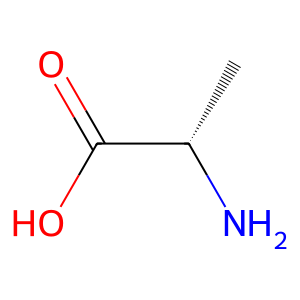

SMILES: CCO, Predicted Lipophilicity: [0.296875]


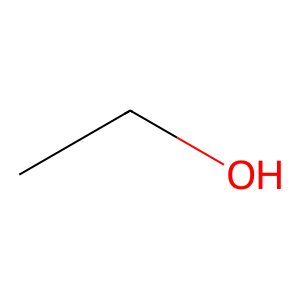

SMILES: CCN(CC)CC, Predicted Lipophilicity: [0.91796875]


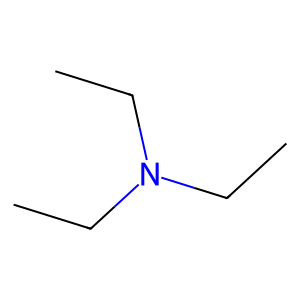

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import torch
import openvino.runtime as ov

# Load your PyTorch model (assuming it's already trained and saved)
model = Net()  # Replace with your model class
model.load_state_dict(torch.load('lipophilicity_model.pth'))
model.eval()

# OpenVINO setup (assuming you have already converted your model)
core = ov.Core()
ov_model = core.read_model('./lipophilicity_openvino.xml')
compiled_model = core.compile_model(ov_model, "CPU")

def predict_and_visualize(smiles):
    # Convert SMILES to fingerprint
    fp = smiles_to_fp(smiles)
    input_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0)
    input_numpy = input_tensor.numpy()

    # Create OpenVINO tensor
    ov_input_tensor = ov.Tensor(input_numpy)

    # Run model inference
    result = compiled_model([ov_input_tensor])[0]
    predicted_lipophilicity = result[0]

    # Visualize molecule
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)

    return predicted_lipophilicity, img

# Example usage
smiles_list = ["C[C@H](N)C(=O)O", "CCO", "CCN(CC)CC"]  # Replace with your SMILES strings
for smiles in smiles_list:
    lipophilicity, img = predict_and_visualize(smiles)
    print(f"SMILES: {smiles}, Predicted Lipophilicity: {lipophilicity}")
    display(img)
